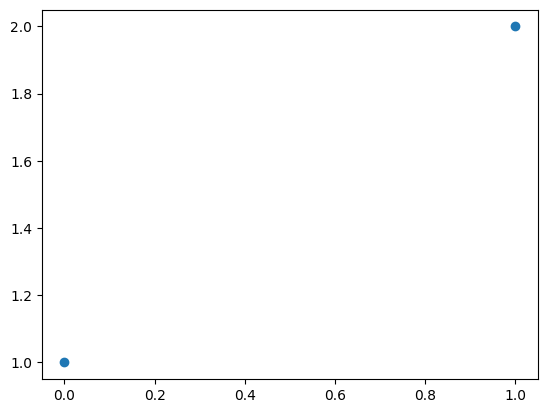

In [1]:
import sys
sys.path.append('f:/seismic/code/core')
sys.path.append('/seismic/code/core')
sys.path.append('/kaggle/input/my-seis-library/')
import kaggle_support as kgs
import importlib
import numpy as np
import matplotlib.pyplot as plt
import glob
import copy
import os
plt.scatter([0,1],[1,2])
#fls.download_kaggle_dataset('jeroencottaar/byu-many-models-2/', fls.result_dir + '/many_full_res/')

In [2]:
importlib.reload(kgs)
data=kgs.load_all_train_data(validation_only=True)
print(len(data))
for d in data:
    d.check_constraints()
import seis_nn
model = seis_nn.default_pretrained
model.batch_size = 16
data = model.infer(data)
data2 = []

5000
F:/seismic/models/brendan/*.pth
Loading:  F:/seismic/models/brendan\unet2d_caformer_seed3_epochbest.pt
n_models: 1


Importing cache brendan: 100%|████████████████████████████████████████████████████| 5000/5000 [00:19<00:00, 258.49it/s]


In [12]:
vals_not = []
vals = []
import seis_model
import cupy as cp
def kpi_fault_A(mat):
    #plt.figure();plt.imshow(mat.get());
    means = cp.mean(mat,axis=1)
    diffs = cp.abs(mat-means[:,None])
    diffs = cp.max(diffs,axis=1)
    #plt.figure();plt.plot(diffs.get())
    v0 = means[0]
    v1 = means[-1]
    means = means[diffs<50]
    if len(means)<20:
        return 1000
    
    diffs2 = cp.minimum(cp.abs(means-v0),cp.abs(means-v1))
    #plt.figure();plt.plot(diffs2.get())
    #kpi = cp.sum(diffs<50).get()
    return cp.max(diffs2).get()

def kpi_fault_A(mat):
    #plt.figure();plt.imshow(mat.get());
    means = cp.median(mat,axis=1)
    v0 = means[0]
    v1 = means[-1]    
    diffs2 = cp.minimum(cp.abs(mat-v0),cp.abs(mat-v1))
    #plt.figure();plt.plot(cp.sort(diffs2.flatten()).get())
    #kpi = cp.sum(diffs<50).get()
    return cp.percentile(diffs2.flatten(),95).get()

# d=data[500]
# d.velocity.load_to_memory()
# print(kpi_fault_A(d.velocity.data));plt.title(d.family)
# raise 'stop'

# plt.figure();
# for d in data[0:3000][::10]:
#     d.velocity.load_to_memory()
#     kpi_style_B(d.velocity.data)
# plt.xlim([4800,4910])
# plt.ylim([0,20])
# plt.figure();
# for d in data[4500:][::10]:
#     d.velocity.load_to_memory()
#     kpi_style_B(d.velocity.data)
# plt.xlim([4800,4910])
# plt.ylim([0,20])

from tqdm import tqdm
import cupy as cp
kpi_vals = []
err_vals = []
families = []
import seis_forward2
data_todo = data
for iid,d in tqdm(enumerate(data_todo), total=len(data_todo)):
    if 'FlatVel' in d.family or 'Style' in d.family:
        continue # done already
    families.append(d.family)
    #if not d.family=='CurveFault_B':
    #    continue
    d.velocity.load_to_memory()
    #d = model.infer([d])[0]
    d.velocity_guess.to_cupy()
    #x = d.velocity_guess.to_vector()        
    kpi = kpi_fault_A(d.velocity_guess.data)#np.log(cp.asnumpy(x[:-1,:].T@(prior.P)@x[:-1,:])[0,0])
    #kpi = cp.asnumpy(kgs.rms(d.seismogram.data[0,...] - cp.flip(d.seismogram.data[4,...],axis=1)))
    # if 'Fault_A' in d.family:
    #     vals.append(kpi)
    #     #if kpi>20:
    #     #    plt.figure();plt.imshow(d.velocity.data.get());plt.colorbar();plt.title(d.cache_name()+', '+str(kpi))
    # else:
    #     vals_not.append(kpi)       
    #     #if kpi<20.:
    #     #    print(iid)
    #     #    plt.figure();plt.imshow(d.velocity.data.get());plt.colorbar();plt.title(d.cache_name()+', '+str(kpi)+', '+str(iid))
    d.seismogram.load_to_memory()
    seis = copy.deepcopy(d.seismogram)
    seis.from_vector(seis_forward2.vel_to_seis(d.velocity_guess.to_vector().astype(kgs.base_type_gpu))[0])
    kpi_vals.append(kgs.rms(seis.data-d.seismogram.data).get())
    #kpi_vals.append(kpi)
    err_vals.append(cp.mean(cp.abs(d.velocity.data-d.velocity_guess.data)).get())
    d.unload()

100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [02:56<00:00, 28.32it/s]


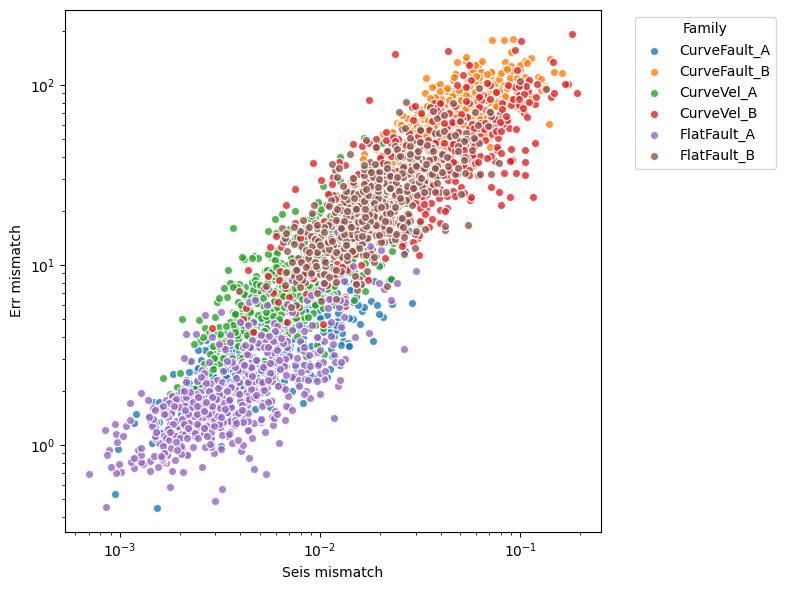

In [16]:
df = pd.DataFrame({'fam':families, 'kpi':kpi_vals, 'err':err_vals})
fig, ax = plt.subplots(figsize=(8,6))
for family, grp in df.groupby('fam'):
    ax.scatter(
        grp['kpi'],
        grp['err'],
        label=family,
        #s=grp.get('points', 20),   # optional: scale marker size by ‘points’
        alpha=0.8,
        edgecolors='w'
    )

plt.xscale('log')
plt.yscale('log')
ax.set_xlabel('Seis mismatch')
ax.set_ylabel('Err mismatch')
#ax.set_title('Guess Error vs. Residual by Family')
ax.legend(title='Family', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
#plt.show()

In [11]:
len(kpi_vals), len(families)

(3000, 5000)

ValueError: zero-size array to reduction operation maximum which has no identity

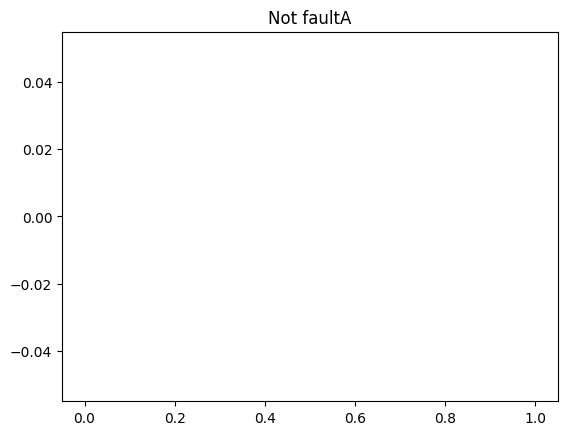

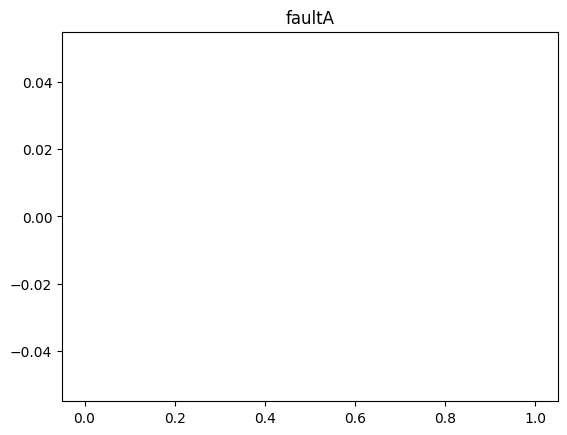

In [6]:
plt.figure()
vals_not = np.array(vals_not)
plt.hist(vals_not[vals_not<200])
plt.title('Not faultA')
plt.figure()
plt.hist(vals)
plt.title('faultA')
np.max(vals), np.min(vals_not)